## Geoscience Australia 9s DEM Map of Tasmania

Here we show a workflow for handling the higher resolution (9 arc second) DEM of Tasmania supplied by Geoscience Australia. This has been clipped using gdaltranslate to capture the area of interest and save it as a geotiff file. This has roughly 2.4 million points on the island of Tasmania. This DEM is hydrologically enforced at the outset and therefore serves as a consistency test for the `quagmire` flow algorithms etc. 

In this notebook, we read the original DEM, check it for consistency and (SPOILER !) make a few adjustments to account for peculiarities of the DEM associated with the various dams in the hydro-schemes. 

We then save the processed DEM ... 
(TODO: parallel HDF5 would be better)

### Dependencies

  - `quagmire` 
  - `gdal`     - used to read and write geotiff files
  - `cartopy`  - to produce maps
  - `lavavu`   - for 3D visualisations


In [1]:
import numpy as np
import quagmire
from quagmire import function as fn
from quagmire import tools as meshtools

import gdal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
file = "data/dem9s-tassie.tif"
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
height = band.ReadAsArray()
[cols, rows] = height.shape

left, hres, n0, top, n1, vres  = ds.GetGeoTransform()
right = left+rows*hres
bottom = top+cols*vres
x,y = np.meshgrid(np.arange(left, right, hres), np.arange(top,  bottom, vres))

## Re-write without infinities !

arr_out = np.where((height < 0.0), -10.0, height)
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("dem9s-Tassie-no_bath.tif", rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(ds.GetGeoTransform())      ##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())          ##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(-10.0)     ##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None



In [3]:
ds = gdal.Open(file)
ds.GetProjection()

'GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4283"]]'

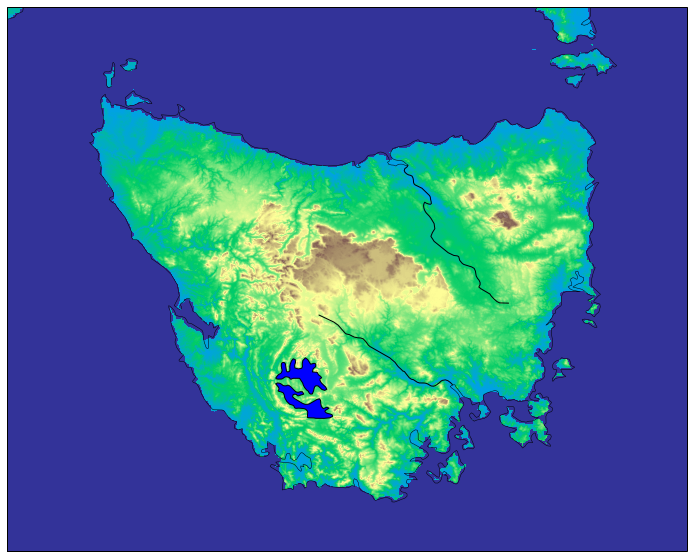

In [4]:
## Plot the heights as a map


import cartopy.crs as ccrs
import cartopy.feature as cfeature

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="blue")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="green",
                           facecolor="blue")

map_extent = ( left, right, bottom, top)

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

plt.imshow(height, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='terrain', origin='upper', vmin=-400., vmax=2000.)

# cb = plt.colorbar(orientation='vertical')
# cb.set_label('Altitude')
# plt.title("SRTM Map")
# gl = ax.gridlines(draw_labels=True)
# gl.xlabels_top = False
# gl.ylabels_left = False


In [5]:
# filter out the points off the coast that are all set to an elevation of -inf 
# create a smooth transition for points that are close to the coastline 

## This image is 1.0 on land, -1.0 in the water. Applying
## a smoothing filter will turn that into a slope that
## we can use 

from scipy.ndimage.filters import gaussian_filter

landmask  = np.where((height < 0.0), -1.0, 1.0)
smoothedmask = gaussian_filter(landmask, 0.75)
point_mask =  smoothedmask > -0.9

#corners
point_mask[0,0] = 1.0
point_mask[0,-1] = 1.0
point_mask[-1,0] = 1.0
point_mask[-1,-1] = 1.0


xs = x[point_mask]
ys = y[point_mask]
heights = 0.001 * height[point_mask]  ## in km 
points = np.column_stack([xs, ys])

submarine = (heights <  0.0 )
subaerial = (heights >= 0.0 )

heights[submarine] = 0.001 * smoothedmask[point_mask][submarine]


In [76]:
point_mask.shape

(1600, 2000)


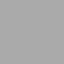

In [6]:
import lavavu
import stripy

vertices = np.column_stack([xs, ys, 0.1 * heights])
tri = stripy.Triangulation(xs, ys, permute=True)

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

sa = lv.points("subaerial", colour="red", pointsize=0.2, opacity=0.75)
sa.vertices(vertices[subaerial])

tris = lv.triangles("mesh",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices)
tris.indices(tri.simplices)
tris.values(heights, label="elevation")
tris.colourmap('dem3')
cb = tris.colourbar()

sm = lv.points("submarine", colour="blue", pointsize=0.5, opacity=0.75)
sm.vertices(vertices[submarine])

lv.control.Panel()
lv.control.ObjectList()
# tris.control.Checkbox(property="wireframe")
lv.control.show()


In [7]:
DM = meshtools.create_DMPlex_from_points(xs, ys, bmask=subaerial)
mesh = quagmire.SurfaceProcessMesh(DM, downhill_neighbours=3)

0 - Delaunay triangulation 15.457579207000002s
0 - Calculate node weights and area 0.2836391479999918s
0 - Find boundaries 0.04240402699998924s
0 - cKDTree 0.2872809939999996s
0 - Construct neighbour cloud array 6.145637640000004s
0 - Construct rbf weights 1.5132227489999934s


In [8]:
with mesh.deform_topography():
    mesh.topography.data = heights
                                                                               

0 - Build downhill matrices 4.724744433999987s
0 - Build upstream areas 23.44130521599999s


In [9]:
low_points1 = mesh.identify_low_points()
low_point_coords1 = mesh.coords[low_points1] 
print(low_points1.shape)

cumulative_flow_1 = mesh.upstream_integral_fn(mesh.topography).evaluate(mesh)
topography_1 = mesh.topography.data[:]

outflow_points1 = np.unique(np.hstack(( mesh.identify_outflow_points(), mesh.identify_low_points())))
upstream_area1  = mesh.upstream_integral_fn(fn.misc.levelset(mesh.topography, 0.0)).evaluate(mesh)

(225,)


In [10]:
mesh.topography.data.min()

-0.0010000000474974513

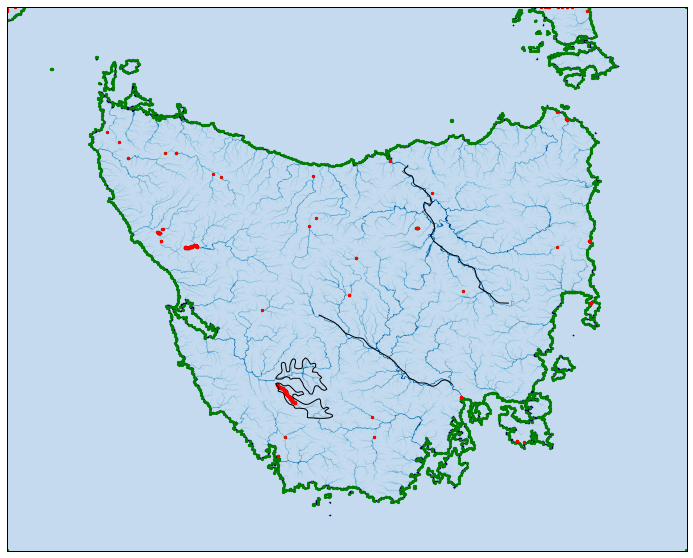

In [11]:
## plot the results

logflow = np.log10(1.0e-3+upstream_area1)
flows1 = logflow.min() * np.ones_like(height)
flows1[point_mask] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

# ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

ax.add_feature(lakes,     edgecolor="black", facecolor="none", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

ax.scatter(xs[submarine],ys[submarine], color="#000044", s=.1)
# ax.tricontour(xs,ys, 1000.0*heights, triangles=mesh.tri.simplices, levels=[100,500,1000,1500], linewidths=0.5, colors="Black")

plt.imshow(flows1, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-1.5)

ax.scatter(xs[outflow_points1], ys[outflow_points1], color="Green", s=5)
ax.scatter(xs[low_points1], ys[low_points1], color="Red", s=5)


plt.savefig("WEx3-Flowpath-1.png", dpi=250)

## Apply pit filling / local-flooding / swamp filling algorithm

The pit filling is for very small local minima where the basin filling / swamp algorithm is not appropriate. The local flooding is a simple upward height propagation from a blockage with a limit on the distance that it can propagate. 

The swamp algorithm is for extensive regions that have only internal drainage. Some changes to the identification of "erroneous" low points is needed for cases where internal drainages are expected.

At least one extra round of iteration is often helpful.

In this case, the hydrologically enforced DEM should not have any local minima but there are some issues that are associated with water bodies that are dammed and this does, as a result, need a little modification which we compute here and analyse after the fact. 

In [12]:
for repeat in range(0,2):

    mesh.low_points_local_patch_fill(its=2, smoothing_steps=2)
    topography_2 = mesh.topography.data[:]
    cumulative_flow_2 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
    low_points2 = mesh.identify_low_points()
    low_point_coords2 = mesh.coords[low_points2] 
    print("Low points - {}".format(low_points2.shape))

    for i in range(0,10):
        mesh.low_points_swamp_fill(ref_height=-0.01, ref_gradient=0.001)

        # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
        low_points3 = mesh.identify_global_low_points()

        print("{} : {}".format(i,low_points3[0]))
        if low_points3[0] == 0:
            break
 

Low point local patch fill
0 - Build downhill matrices 4.682918366999985s
0 - Build downhill matrices 4.734951106000011s
Low point local patch fill  10.688283643999995  seconds
0 - Build upstream areas 21.522586093s
Low points - (47,)
862  iterations, time =  21.355889822999984
Build low point catchments -  21.365623073999984  seconds
0  Sort spills -  0.023819372999980715
0  Gather spill data -  0.00017807399999014706
0  Sort all spills -  5.6461999974999344e-05
0 - Build downhill matrices 4.358207401000016s
Low point swamp fill  25.919477350999983  seconds
0 - Build upstream areas 20.430156573000005s
0 : 18
774  iterations, time =  16.983179157999984
Build low point catchments -  16.98972123300001  seconds
0  Sort spills -  0.022314361000042027
0  Gather spill data -  9.45300000125826e-05
0  Sort all spills -  5.2550000020801235e-05
0 - Build downhill matrices 4.512212776999945s
Low point swamp fill  21.669168093999986  seconds
0 - Build upstream areas 20.725860970999975s
1 : 9
773  

In [13]:
cumulative_flow_3 = mesh.upstream_integral_fn(mesh.topography**2).evaluate(mesh)
low_points3 = mesh.identify_low_points()
topography_3 = mesh.topography.data[:]
print("Low points - {}".format(low_points3.shape))

Low points - (0,)


In [14]:
# Generally, there are no low points but sometimes on the boundaries these are not avoidable or worth fixing
outflow_points3 = np.unique(np.hstack(( mesh.identify_outflow_points(), mesh.identify_low_points())))
upstream_area3  = mesh.upstream_integral_fn(fn.misc.levelset(mesh.topography, 0.0)).evaluate(mesh)

In [15]:
hdiff = height.copy()
hdiff[point_mask]  = 1000.0 * (mesh.topography.data - heights)
hdiff[~point_mask] = 0.0

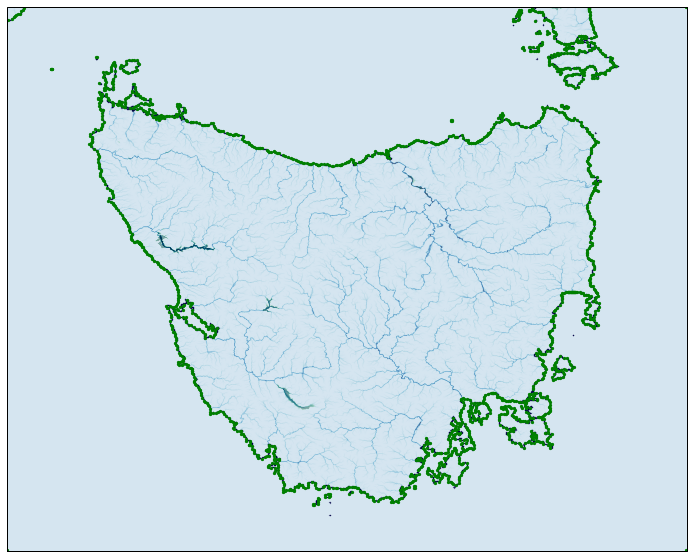

In [16]:
logflow = np.log10(1.0e-3+upstream_area3)
flows3 = logflow.min() * np.ones_like(height)
flows3[point_mask] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.scatter(xs[submarine],ys[submarine], color="#000044", s=.05)

plt.imshow(flows3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Blues', origin='upper', vmin=-3.5, vmax=-1.5)

plt.imshow(hdiff, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greens', origin='upper', vmin=0.0, vmax=10, alpha=0.333)

ax.scatter(xs[outflow_points3], ys[outflow_points3], color="Green", s=5)
ax.scatter(xs[low_points3], ys[low_points3], color="Red", s=5)


plt.savefig("WEx3-Flowpath-3.png", dpi=250)

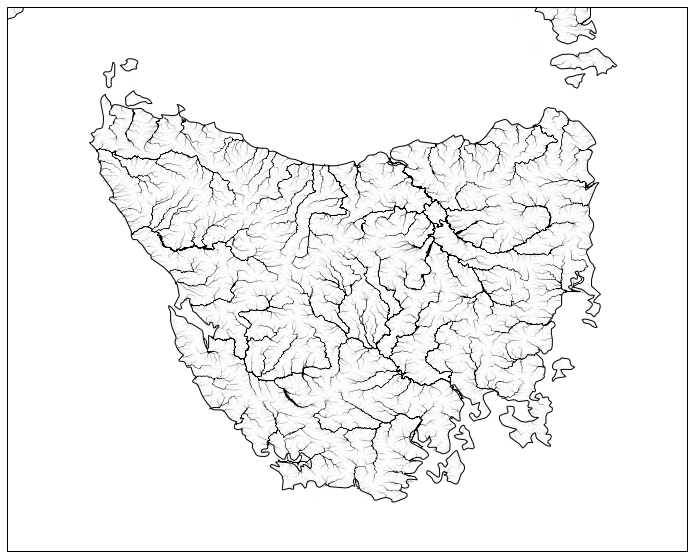

In [17]:
logflow = np.log10(1.0e-3+upstream_area3)
flows3 = logflow.min() * np.ones_like(height)
flows3[point_mask] = logflow

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=30)

plt.imshow(flows3, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greys', origin='upper', vmin=-3.0, vmax=-2.5)

# plt.imshow(hdiff, extent=map_extent, transform=ccrs.PlateCarree(),
#            cmap='Greens', origin='upper', vmin=0.0, vmax=10, alpha=0.333)



plt.savefig("WEx3-Flowpath-BW.png", dpi=500)

In [18]:
# Save post-processed topography / also without infinities !

hnew = np.zeros_like(height, dtype=float)
hnew[point_mask]  = 1000.0 * mesh.topography.data
hnew[~point_mask] = -1.0

ds = gdal.Open(file)
arr_out = hnew

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("dem9s-tassie-quagmire.tif", rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(ds.GetGeoTransform())      ##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())          ##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(-10.0)     ##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

In [73]:
norm = matplotlib.colors.Normalize(vmin=-3.5,vmax=-1.5)
im = cm.Blues(norm(flows3))
im[..., 0:3][~point_mask] = 1.0 


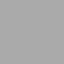

In [74]:
catch = np.zeroes_like(height)
catch[point_mask] = 
im = cm.gist_rainbow(norm())
im[..., 0:3][~point_mask] = 1.0 


import lavavu

points = np.column_stack([mesh.tri.points, 0.1*mesh.topography.data])

low_point_coords3 = points[low_points3]
outflow_point_coords3 = points[outflow_points3]

low_point_coords1 = points[low_points1]

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.texture(im)

# lows1 = lv.points("lowsO", colour="#550011", pointsize=10.0, opacity=0.75)
# lows1.vertices(low_point_coords1)

# lows = lv.points("lows", colour="red", pointsize=10.0, opacity=0.75)
# lows.vertices(low_point_coords3)

# outflows = lv.points("outflows", colour="green", pointsize=10.0, opacity=0.75)
# outflows.vertices(outflow_point_coords3)

lv.control.Panel()
lv.control.ObjectList()
# tri1.control.List(options=["cum-flow-orig",
#                            "cum-flow-pit", 
#                            "cum-flow-pit-swamp"
#                           ], property="colourby", command="redraw")

# tri2.control.List(options=["blank", "swamps", 
#                    "cum-rain-swamp"], property="colourby", command="redraw")


lv.control.show()